<a href="https://colab.research.google.com/github/bethuunltd/DBMSProj2-2/blob/main/Param_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date')
print(df['date'])
parameter = df[['ws']]
lookback = 10
horizon = 5

scaler = MinMaxScaler()

train_len = 0.7*len(parameter)
val_len = 0.2*len(parameter)

train = parameter[:int(train_len)]
val = parameter[int(train_len):int(train_len+val_len)]
test = parameter[int(train_len+val_len):]


#The scaler has no cross-contamination between features.
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

train_scaled.shape,val_scaled.shape,test_scaled.shape







0       2016-01-01 00:00:00
1       2016-01-01 01:00:00
2       2016-01-01 02:00:00
3       2016-01-01 03:00:00
4       2016-01-01 04:00:00
                ...        
44683   2021-02-04 19:00:00
44684   2021-02-04 20:00:00
44685   2021-02-04 21:00:00
44686   2021-02-04 22:00:00
44687   2021-02-04 23:00:00
Name: date, Length: 44688, dtype: datetime64[ns]


((31281, 1), (8938, 1), (4469, 1))

In [4]:
def create_sequences(data,lookback,horizon):
  X,y = [],[]
  for i in range(len(data)-lookback-horizon):
    X.append(data[i:i+lookback])
    y.append(data[i+lookback:i+lookback+horizon])#Starts from the last datapoint of X, and goes "horizon" days more.
  return np.array(X),np.array(y)


X_train,y_train = create_sequences(train_scaled,lookback,horizon)
X_val,y_val = create_sequences(val_scaled,lookback,horizon)
X_test,y_test = create_sequences(test_scaled,lookback,horizon)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()



In [5]:
class forecast_LSTM(nn.Module):
  def __init__(self,input_size =1,hidden_size = 64, num_layers=2,horizon = 5,dropout=0.3):
    super().__init__()
    self.horizon = horizon
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=0.3)
    self.fc = nn.Linear(hidden_size,horizon*input_size)



  def forward(self,x):
     h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size)
     c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size)
     out,_  = self.lstm(x,(h0,c0))
     out = self.fc(out[:,-1,:])
     out = out.view(-1,self.horizon,self.input_size)
     return out

#model = forecast_LSTM()

#criterion =  nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(),lr=0.005)




In [6]:
epochs = 80
train_set = TensorDataset(X_train,y_train)
train_loader = DataLoader(train_set,batch_size=32,shuffle=False,drop_last=True)#Experiment with this to see which gives best evaluation
val_set = TensorDataset(X_val,y_val)
val_loader = DataLoader(val_set,batch_size = 32,shuffle=False,drop_last = True)
test_set = TensorDataset(X_test,y_test)
test_loader = DataLoader(test_set,batch_size=32,shuffle=False,drop_last = True)

In [7]:
class EarlyStopping:
  def __init__(self, patience=3,window = 5,min_delta = 0.000001):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_average = None
    self.window = window
    self.early_stop = False
    self.val_losses = []

  def moving_average(self,values):
    if len(values) >= self.window:
      return np.mean(values[-self.window:])
    else: return np.mean(values)

  def __call__(self,val_loss):
    self.val_losses.append(val_loss)
    average = self.moving_average(self.val_losses)
    if self.best_average is None:
      best_average = average
    elif self.best_average-min_delta>=average:
      self.best_average = average
      self.counter = 0
    else:
      self.counter +=1
      if self.counter >= self.patience:
        self.early_stop = True



In [ ]:

print(loss)
criterion = nn.MSELoss()
with torch.no_grad():
  model.eval()
  losses = []
  for X_test,y_test in test_loader:
    y_test_pred = model(X_test)
    loss = criterion(y_test_pred,y_test)
    losses.append(loss.item())

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 5, 2])) that is different to the input size (torch.Size([32, 6, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (6) must match the size of tensor b (5) at non-singleton dimension 1

In [ ]:

model = forecast_LSTM()
epochs = 80
criterion =  nn.MSELoss()
early_stopper = EarlyStopping(patience=7,window=5)
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
best_model = None
best_val_loss = np.inf#Returns a floating point infinity

for epoch in range(epochs):
  model.train()
  epoch_loss = 0
  for X_train,y_train in train_loader:
    optimizer.zero_grad()
    y_pred = model(X_train)
    y_pred.shape,y_train.shape
    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  epoch_loss /= len(train_loader)

  if (epoch+1)%5 ==0:
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')


  model.eval()
  with torch.no_grad():
    val_loss = 0
    for X_val,y_val in val_loader:
      y_val_pred = model(X_val)
      loss = criterion(y_val_pred,y_val)
      val_loss += loss.item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = model

    if early_stopper.early_stop:
      print(f"Early stopping at epoch {epoch+1}")
      break







/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 5, Loss: 0.007990779355168343
Epoch: 10, Loss: 0.006820014212280512
Epoch: 15, Loss: 0.005382935982197523
Epoch: 20, Loss: 0.004877428524196148
Epoch: 25, Loss: 0.004798992536962032


In [ ]:
model = best_model

for epoch in range(20):
  model.train()
  epoch_loss = 0
  for X_train,y_train in train_loader:
    optimizer.zero_grad()
    y_pred = model(X_train)
    y_pred.shape,y_train.shape
    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  epoch_loss /= len(train_loader)

  if (epoch+1)%5 ==0:
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')


  model.eval()
  with torch.no_grad():
    val_loss = 0
    for X_val,y_val in val_loader:
      y_val_pred = model(X_val)
      loss = criterion(y_val_pred,y_val)
      val_loss += loss.item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = model

    if early_stopper.early_stop:
      print(f"Early stopping at epoch {epoch+1}")
      break



Epoch: 5, Loss: 0.0014864911790937185
Epoch: 10, Loss: 0.0014865424018353224
Epoch: 15, Loss: 0.0014865818666294217
Epoch: 20, Loss: 0.0014866138808429241


In [9]:
from sklearn.metrics import r2_score
best_model.eval()
with torch.no_grad():
  losses = []
  for X_test,y_test in test_loader:
    y_test_pred = best_model(X_test)
    loss = criterion(y_test_pred,y_test)
    losses.append(loss.item())
    print(f'Test Loss: {loss.item()}')

  print(f'Average Test Loss: {np.mean(losses)}')

# Flatten over time and batch for R²
y_true_flat = y_test.numpy().reshape(-1, y_test.shape[-1])
y_pred_flat = y_test_pred.numpy().reshape(-1, y_test_pred.shape[-1])

# Compute R² separately for each feature
r2_ap = r2_score(y_true_flat[:, 0], y_pred_flat[:, 0])   # Air Pressure
#r2_ws = r2_score(y_true_flat[:, 1], y_pred_flat[:, 1])   # Wind Speed

print(f"R² for Air Pressure: {r2_ap:.4f}")
#print(f"R² for Wind Speed: {r2_ws:.4f}")

Test Loss: 0.012006877921521664
Test Loss: 0.018223658204078674
Test Loss: 0.008783137425780296
Test Loss: 0.0030948612838983536
Test Loss: 0.004273762460798025
Test Loss: 0.008532656356692314
Test Loss: 0.01596764102578163
Test Loss: 0.004525411874055862
Test Loss: 0.0023316636215895414
Test Loss: 0.012183508835732937
Test Loss: 0.04282059893012047
Test Loss: 0.00804581493139267
Test Loss: 0.01240380760282278
Test Loss: 0.00673582311719656
Test Loss: 0.005337245762348175
Test Loss: 0.011567529290914536
Test Loss: 0.0025534096639603376
Test Loss: 0.003388953860849142
Test Loss: 0.0012954726116731763
Test Loss: 0.002883349312469363
Test Loss: 0.014260562136769295
Test Loss: 0.004500934388488531
Test Loss: 0.006744620390236378
Test Loss: 0.0057890089228749275
Test Loss: 0.005430153571069241
Test Loss: 0.003644355107098818
Test Loss: 0.006824019365012646
Test Loss: 0.005203737411648035
Test Loss: 0.01609174907207489
Test Loss: 0.005988887045532465
Test Loss: 0.00195694575086236
Test Loss:

In [10]:
torch.save(best_model.state_dict(),'Parameters_combined.pt')

In [ ]:
def recursive_forecast(model,initial_seq,steps_ahead,lookback,scaler,horizon=5):
  model.eval()
  predictions = []
  curr_input = initial_seq.copy()
  with torch.no_grad():
    while len(predictions)*horizon < steps_ahead:
      input_tensor = torch.tensor(curr_input).unsqueeze(0).float()
      forecast = model(input_tensor).squeeze(0).numpy()#Model output: 1,horizon,features --> horizon,features
      predictions.append(forecast)
      curr_input = np.vstack([curr_input,forecast])#Shape: (lookback+horizon,features)
      curr_input = curr_input[-lookback:]#Keeps only the latest 'lookback' number of rows

    predictions = np.vstack(predictions)[:steps_ahead]#Combines all forecast blocks into one array and cuts to exactly steps_ahead
    predictions_actual = scaler.inverse_transform(predictions)#Reverses the MinMax Scaling to give it in acatual units
    return predictions_actual




In [ ]:
initial_seq = test_scaled[-lookback:]  # use last known real sequence

# Predict next 3 months
steps_ahead = 720  # 90 days * 24 hours
future_forecast = recursive_forecast(best_model, initial_seq, steps_ahead, lookback, scaler, horizon=horizon)

# Create future datetime index



last_date = df['date'].iloc[-1]  # this will now be a datetime
print(last_date)
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=steps_ahead, freq='h')


# Convert forecast to dataframe
future_forecast_df = pd.DataFrame(future_forecast, columns=['ap', 'ws'], index=future_dates)


2021-02-04 23:00:00


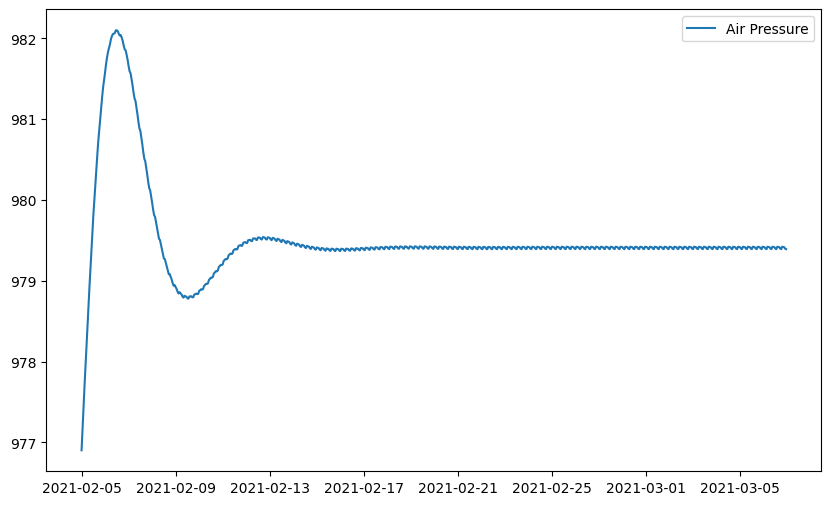

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(future_forecast_df.index,future_forecast_df['ap'],label='Air Pressure')
plt.legend()
plt.savefig('air_pressure.png')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

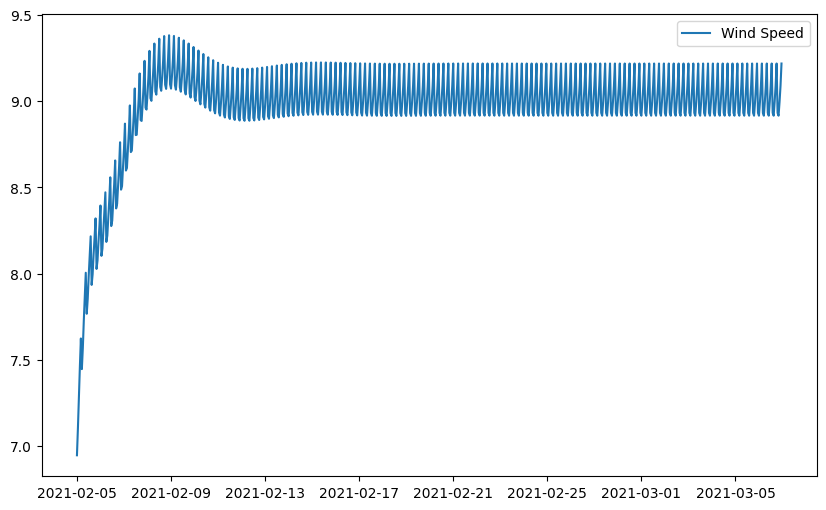

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(future_forecast_df.index,future_forecast_df['ws'],label='Wind Speed')
plt.legend()
plt.savefig('ws.png')
plt.show
